# ChoiWu2021-JEDC-SABR-CEV

### Title: 
__The equivalent constant-elasticity-of-variance (CEV) volatility of the stochastic-alpha-beta-rho (SABR) model__

### Authors:
* Jaehyuk Choi ([@jaehyukchoi](https://github.com/jaehyukchoi))
* Lixin Wu

### Abstract:
This study presents new analytic approximations of the stochastic-alpha-beta-rho (SABR) model. Unlike existing studies that focus on the equivalent Black–Scholes (BS) volatility, we instead derive the equivalent constant-elasticity-of-variance (CEV) volatility. Our approach effectively reduces the approximation error in a way similar to the control variate method because the CEV model is the zero vol-of-vol limit of the SABR model. Moreover, the CEV volatility approximation yields a finite value at a zero strike and thus conveniently leads to a small-time asymptotics for the mass at zero. The numerical results compare favorably with the BS volatility approximations in terms of the approximation accuracy, small-strike volatility asymptotics, and no-arbitrage region.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
import scipy as sp

#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf

In [3]:
# uncomment and run to see the all available parameter sets
#pf.SabrHagan2002.init_benchmark()

## Table 2/3/4 and Figure 3 (a-c) (Set 1/2/3) 

In [4]:
# 1 (Table 2, Figure 3a), 2 (Table 3, Figure 3b), 3 (Table 4, Figure 3c)
param_set = 1

assert param_set in [1,2,3]
set_no = {1:20, 2:19, 3:17}[param_set]

m_bsA, df, ref = pf.SabrHagan2002.init_benchmark(set_no)
m_cevA, *_ = pf.SabrChoiWu2021H.init_benchmark(set_no)
m_cevB, *_ = pf.SabrChoiWu2021P.init_benchmark(set_no)
m_bsC, *_ = pf.SabrLorig2017.init_benchmark(set_no)

fwd = ref['args_pricing']['spot']
texp = ref['args_pricing']['texp']
strike_exact = ref['args_pricing']['strike']
alpha = m_bsA.sigma/np.power(ref['args_pricing']['spot'],1.0-m_bsA.beta)

if ref['is_iv']:
    vol_exact = ref['val']
    p_exact = pf.Bsm(ref['val']).price(**ref['args_pricing'])
else:
    p_exact = ref['val']
    vol_exact = pf.Bsm(None).impvol(ref['val'], **ref['args_pricing'])

m0_exact = {20: 0.1634, 19: 0.7758, 17: 0.2220}[set_no]

In [5]:
vol_bsA = m_bsA.vol_for_price(**ref['args_pricing'])
vol_bsC = m_bsC.vol_for_price(**ref['args_pricing'])
vol_cevA = m_cevA.vol_smile(**ref['args_pricing'])

m_cevB._base_beta = None
vol_cevB = m_cevB.vol_smile(**ref['args_pricing'])

m_cevB._base_beta = 1.0
vol_bsB = m_cevB.vol_smile(**ref['args_pricing'])

vol_err = (np.array([vol_bsA, vol_bsB, vol_bsC, vol_cevA, vol_cevB]) - vol_exact)/alpha
exact = np.array([vol_exact*100, p_exact])

In [6]:
pd.DataFrame(
    np.hstack([vol_err.T, exact.T]), index=strike_exact/fwd,
    columns=['BS-A', 'BS-B', 'BS-C', 'CEV-A', 'CEV-A', 'Exact $\sigma_{BS}$', 'Exact P']
)

,BS-A,BS-B,BS-C,CEV-A,CEV-A,Exact $\sigma_{BS}$,Exact P
0.868123,0.026870,0.026817,0.004192,0.024417,0.024344,74.187422,0.221383
1.000000,0.023573,0.023573,0.002721,0.021659,0.021659,71.666002,0.193837
1.151910,0.020901,0.020843,0.001598,0.019423,0.019345,69.325033,0.166241


In [7]:
strike = np.power(10, np.arange(-2.5,1,0.025))*fwd
strike_low = np.power(10, np.concatenate((np.arange(-2.5,0,0.05), np.arange(-0.05,-0.005,0.005))))*fwd

m_cevB._base_beta = 1.0
vol_bsB = m_cevB.vol_smile(strike, fwd, texp)

m_cevB._base_beta = None
vol_cevB = m_cevB.vol_smile(strike, fwd, texp)

vol_dem = m_cevB.vol_from_mass_zero(strike_low, fwd, texp)
vol_dem2 = m_cevB.vol_from_mass_zero(strike_low, fwd, texp, mass=m0_exact)
m0_cevB = m_cevB.mass_zero(fwd, texp)

m_cevB._base_beta = 1.0
vol_bsB = m_cevB.vol_smile(strike*fwd, fwd, texp)

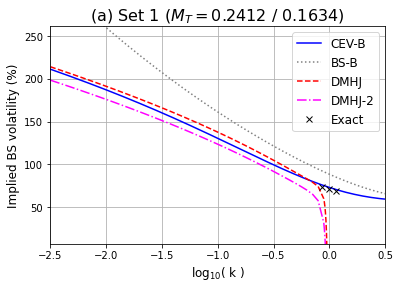

In [8]:
vol_arr = [vol_cevB, vol_bsB, vol_dem, vol_dem2]
K_arr = [strike, strike, strike_low, strike_low]

labels = ['CEV-B', 'BS-B', 'DMHJ', 'DMHJ-2']

ls = ['-', ':', '--', '-.']
colors = ['b', 'gray', 'r', 'magenta']

for k in np.arange(4):  # len(vol_arr)
    plt.plot(np.log10(K_arr[k]/fwd), vol_arr[k]*100, label=labels[k], color=colors[k], linestyle=ls[k])

plt.plot(np.log10(strike_exact/fwd), vol_exact*100, 'kx', label = 'Exact')

plt.xlim([-2.5,0.5])
plt.ylim([min(vol_cevB)*100-50, max(vol_cevB)*100+50])
plt.ylabel('Implied BS volatility (%)', fontsize=12)
plt.xlabel(r'$\log_{10}$( k )', fontsize=12)
plt.legend(fontsize=12, loc=1)

abc = 'abc'[param_set-1]
plt.title(f'({abc}) Set {param_set} ($M_T={m0_cevB:0.4f}$ / {m0_exact:0.4f})', fontsize=16)

plt.grid()
#plt.savefig('../Latex-Etc/images/Set3-DeMarco.pdf', bbox_inches='tight')
plt.show()

## Figure 1

In [9]:
# Select [0, 1, 2, 3, 4, 5]
ind_exact = 0  # 0:base, 1:fwd, 2:sigma, 3:beta, 4:vov

subfig_title = [
    r'(a) Base parameter', 
    r'(b) $F_0 = 0.2$', 
    r'(c) $\sigma_0 = 0.1$', 
    r'(d) $\beta$ = 0.2', 
    r'(e) $\nu$ = 0.4'
][ind_exact]

In [10]:
params = {"sigma": 0.2, "vov": 0.1, "rho": 0, "beta":0.1} # base

texp_exact = np.arange(1,11)/10
log_m_exact = np.array([
    [-3.36585222, -1.96687272, -1.46047053, -1.1908933 , -1.02056457, -0.90185897, -0.81369244, -0.74521469, -0.69023839, -0.64496119],
    [-9.40618218, -5.18722753, -3.71849273, -2.95858225, -2.4889435 , -2.16746276, -1.93224571, -1.75188663, -1.60869713, -1.49192629],
    [-10.5886564, -5.80757216, -4.14740495, -3.29059218, -2.76218756, -2.40113409, -2.13737701, -1.93541265, -1.7752668, -1.64481175],
    [-5.68807177, -3.15635005, -2.26897624, -1.80741883, -1.52102876, -1.3243837 , -1.18015626, -1.06935131, -0.98124325, -0.90929863],
    [-3.14610095, -1.87742179, -1.41669492, -1.17103613, -1.01570233, -0.90742306, -0.82701231, -0.76458422, -0.71449569, -0.67327591]
])

params_all = [
    {"sigma": 0.2, "vov": 0.1, "rho": -0.5, "beta":0.1, "fwd":0.1}, # base
    {"sigma": 0.2, "vov": 0.1, "rho": -0.5, "beta":0.1, "fwd":0.2}, # fwd
    {"sigma": 0.1, "vov": 0.1, "rho": -0.5, "beta":0.1, "fwd":0.1}, # sigma
    {"sigma": 0.2, "vov": 0.1, "rho": -0.5, "beta":0.2, "fwd":0.1}, # beta
    {"sigma": 0.2, "vov": 0.4, "rho": -0.5, "beta":0.1, "fwd":0.1}, # vov
]

In [11]:
params = copy.copy(params_all[ind_exact])
fwd = params["fwd"]
del params["fwd"]

m_cevA = pf.SabrChoiWu2021H(**params)
m_cevB = pf.SabrChoiWu2021P(**params)

texp = np.arange(0.001, 1.01, 0.02)

m0_A = np.array([m_cevA.mass_zero(fwd, t1, log=True) for t1 in texp])
m0_B = np.array([m_cevB.mass_zero(fwd, t1, log=True) for t1 in texp])
T0 = m_cevB.mass_zero_t0(fwd, 1) # texp is not important

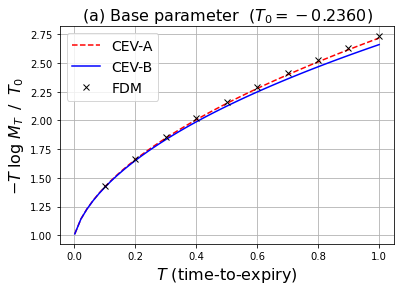

In [12]:
m0_arr = -np.array([m0_A, m0_B])*texp/T0
m0_exact = -log_m_exact[ind_exact]*texp_exact/T0

labels = ['CEV-A', 'CEV-B']
ls = ['--', '-']
colors = ['r', 'b']

for k in np.arange(2):
    plt.plot(texp, m0_arr[k], label=labels[k], color=colors[k], linestyle=ls[k])

plt.plot(texp_exact, m0_exact, 'kx', label = 'FDM')

if ind_exact == 0:
    plt.ylabel(r'$-T\; \log\;M_T\;\; /\;\; T_0$', fontsize=16)
    plt.xlabel(r'$T$ (time-to-expiry)', fontsize=16)

title_T0 = '  ($T_0 = {val:0.4f}$)'.format(val=-T0)
plt.title(subfig_title + title_T0, fontsize=16)

plt.legend(fontsize=14)
plt.grid()
#plt.savefig('../Latex-Etc/images/m0_{num}.pdf'.format(num=ind_exact), bbox_inches='tight')
plt.show()

## Figure 2

In [13]:
# Set 1
param = {"sigma": 0.5, "vov": 0.4, "rho": 0.0, "beta":0.5}
fwd = 0.5

In [14]:
m_cev = pf.Cev(sigma=param['sigma'], beta=param['beta'])
m_cevB = pf.SabrChoiWu2021P(**param)
m_ln = pf.SabrUncorrChoiWu2021(**param)
T0 = m_cevB.mass_zero_t0(spot=fwd, texp=1)

m_mc = pf.SabrMcTimeDisc(**param)
m_mc.set_mc_params(n_path=10e4, dt=0.05, rn_seed=1234)

tarr = np.arange(0, 3.001, 0.25) # Set1
tarr[0] = 0.05
mass0 = [m_ln.mass_zero(fwd, t, log=True) for t in tarr]
mass1 = [m_cevB.mass_zero(fwd, t, log=True) for t in tarr]
mass2 = [m_cev.mass_zero(fwd, t, log=True) for t in tarr]
mass3 = [m_mc.mass_zero(fwd, t, log=True) for t in tarr]
#print(mass0[0], mass1[0], mass2[0])

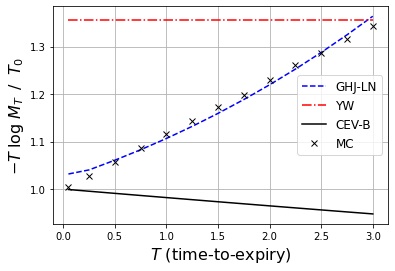

In [15]:
# Figure 2(a)
plt.plot(tarr, -tarr*(mass0)/T0, 'b--', label = 'GHJ-LN')
plt.plot(tarr, -tarr*(mass2)/T0, 'r-.', label = 'YW')
plt.plot(tarr, -tarr*(mass1)/T0, 'k-', label = 'CEV-B')
plt.plot(tarr, -tarr*(mass3)/T0, 'kx', label = 'MC')

plt.ylabel(r'$-T\; \log\;M_T\;\; /\;\; T_0$', fontsize=16)
plt.xlabel(r'$T$ (time-to-expiry)', fontsize=16)
plt.grid()
plt.legend(fontsize=12)

#plt.savefig(f'../Latex-Etc/images/m0_Set1_log.pdf', bbox_inches='tight')
#plt.savefig(f'../Latex-Etc/images/m0_Set1_log.png', bbox_inches='tight')
plt.show()

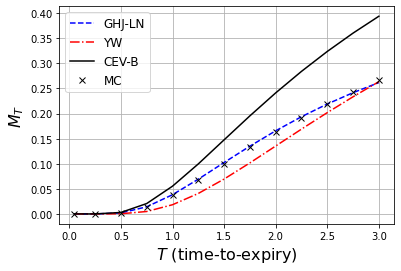

In [16]:
# Figure 2(b)
plt.plot(tarr, np.exp(mass0), 'b--', label = 'GHJ-LN')
plt.plot(tarr, np.exp(mass2), 'r-.', label = 'YW')
plt.plot(tarr, np.exp(mass1), 'k-', label = 'CEV-B')
plt.plot(tarr, np.exp(mass3), 'kx', label = 'MC')

plt.ylabel(r'$M_T$', fontsize=16)
plt.xlabel(r'$T$ (time-to-expiry)', fontsize=16)
plt.grid()
plt.legend(fontsize=12)

#plt.savefig(f'../Latex-Etc/images/m0_Set1_abs.pdf', bbox_inches='tight')
#plt.savefig(f'../Latex-Etc/images/m0_Set1_abs.png', bbox_inches='tight')
plt.show()

## Table 5

In [17]:
params0 = {"sigma": 0.1, "vov": 0.1, "rho": 0, "beta":0.1}
fwd = 0.1
texp = 0.5

In [18]:
rho_arr = np.arange(-3, 0)/10
params = params0.copy()
mass_arr = list()
for rho in rho_arr:
    params['rho'] = rho
    m = pf.SabrChoiWu2021P(**params)
    mass = m.mass_zero(fwd, texp)
    mass_arr.append(mass)
    print(rho, ':', mass, end=' ')

pd.Series(mass_arr, index=None).to_clipboard(excel=True)

-0.3 : 0.06219860721758867 -0.2 : 0.06048185906564118 -0.1 : 0.0587565151871829 

In [19]:
beta_arr = np.arange(1,5)/10
mass_ln = []
mass_mc = []
mass_cevB = []
mass_cev = []

params = params0.copy()
for beta in beta_arr:
    params['beta'] = beta
    m_ln = pf.SabrUncorrChoiWu2021(**params)
    m_cev = pf.Cev(beta=beta, sigma=params['sigma'])
    m_cevB = pf.SabrChoiWu2021P(**params)
    m_mc = pf.SabrMcTimeDisc(**params)
    m_mc.set_mc_params(n_path=20e4, dt=0.05, rn_seed=1234)
    
    mass_ln.append(m_ln.mass_zero(fwd, texp))
    mass_cev.append(m_cev.mass_zero(fwd, texp))
    mass_cevB.append(m_cevB.mass_zero(fwd, texp))
    mass_mc.append(m_mc.mass_zero(fwd, texp))

In [20]:
pd.DataFrame(
    [mass_ln, mass_mc, mass_cevB, mass_cev], index=['GHJ-LN', 'MC', 'CEV-B', 'YB (CEV)'],
    columns=beta_arr
)

,0.1,0.2,0.3,0.4
GHJ-LN,0.056572,0.007966,0.000150,3.197258e-08
MC,0.056570,0.007965,0.000150,3.243808e-08
CEV-B,0.057023,0.008090,0.000155,3.477015e-08
YB (CEV),0.056082,0.007636,0.000124,1.331990e-08
